In [8]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Traversal of the space of cross-validation folds #4

In [9]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

# Ignoring the warning for my models with a split=100%
import warnings

warnings.filterwarnings("ignore")


# Loading the data
data = pd.read_csv("winequality.csv")
data["recommend"] = data["recommend"].astype(int)

# Dropping 'quality' from data
data = data.drop(["quality"], axis=1)

# Scaling the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data.values)
data_scaled = pd.DataFrame(scaled_features, index=data.index, columns=data.columns)
data_scaled["recommend"] = data["recommend"]

# Defining X and Y
X = data_scaled.iloc[:, 0:-1]
y = data_scaled.iloc[:, -1]

# Setting the models to be used
models = []
models.append(("LR", LogisticRegression(solver="lbfgs", random_state=0, max_iter=800)))
models.append(
    (
        "GBC",
        GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0
        ),
    )
)

In [10]:
def model_split(models, X, y, K):
    model_name = []
    k_values = []
    accuracies = []
    precision_scores = []
    recall_scores = []
    global df
    df = pd.DataFrame()

    for name, model in models:
        for value in K:
            kf = KFold(n_splits=value)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                model_name.append(name)
                k_values.append(value)
                current_model = model.fit(X_train, y_train)
                prediction = current_model.predict(X_test)
                accuracy = accuracy_score(y_test, prediction)
                accuracies.append(accuracy)
                precision = precision_score(y_test, prediction, average="binary")
                precision_scores.append(precision)
                recall = recall_score(y_test, prediction, average="binary")
                recall_scores.append(recall)

    df["model_name"] = model_name
    df["k_values"] = k_values
    df["accuracies"] = accuracies
    df["precision_scores"] = precision_scores
    df["recall_scores"] = recall_scores

    return df.groupby(["k_values", "model_name"]).mean()

In [11]:
K = [2, 3, 4, 5, 6, 7, 8, 9, 10]

model_split(models, X, y, K)

accuracies  precision_scores  recall_scores
k_values model_name                                             
2        GBC           0.786443          0.598356       0.349505
         LR            0.790118          0.581776       0.230632
3        GBC           0.790520          0.592214       0.351418
         LR            0.791341          0.618178       0.238188
4        GBC           0.791127          0.595738       0.339410
         LR            0.789294          0.628183       0.212387
5        GBC           0.801337          0.604706       0.378262
         LR            0.795216          0.628171       0.227661
6        GBC           0.807065          0.626126       0.390560
         LR            0.797065          0.633868       0.227683
7        GBC           0.812985          0.631874       0.388477
         LR            0.798079          0.619896       0.231157
8        GBC           0.803183          0.605042       0.368172
         LR            0.798083          0.641728       0.229383
9        GBC           0.803796          0.612387       0.365868
         LR            0.798492          0.628753       0.225240
10       GBC           0.804203          0.594515       0.368001
         LR            0.800123          0.631955       0.229610

In [12]:
# Separating the models
df_LR = df.loc[df["model_name"] == "LR"]
df_GBC = df.loc[df["model_name"] == "GBC"]

# Getting the mean value for accuracy, recall and precision
df_LR_mean = df_LR.groupby(["k_values"]).mean()
df_LR_mean = df_LR_mean.reset_index()

df_GBC_mean = df_GBC.groupby(["k_values"]).mean()
df_GBC_mean = df_GBC_mean.reset_index()

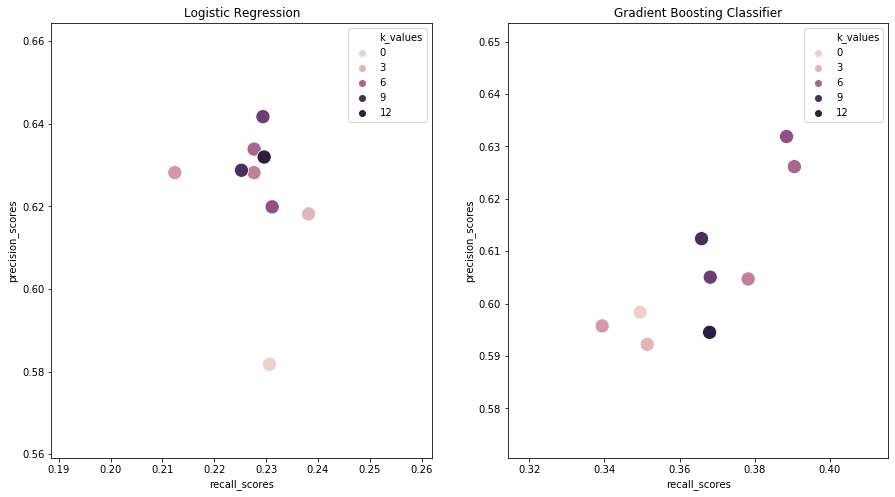

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.scatterplot(
    x=df_LR_mean["recall_scores"],
    y=df_LR_mean["precision_scores"],
    hue=df_LR_mean["k_values"],
    s=200,
    ax=ax[0],
).set_title("Logistic Regression")
sns.scatterplot(
    x=df_GBC_mean["recall_scores"],
    y=df_GBC_mean["precision_scores"],
    hue=df_GBC_mean["k_values"],
    s=200,
    ax=ax[1],
).set_title("Gradient Boosting Classifier")
fig.show()

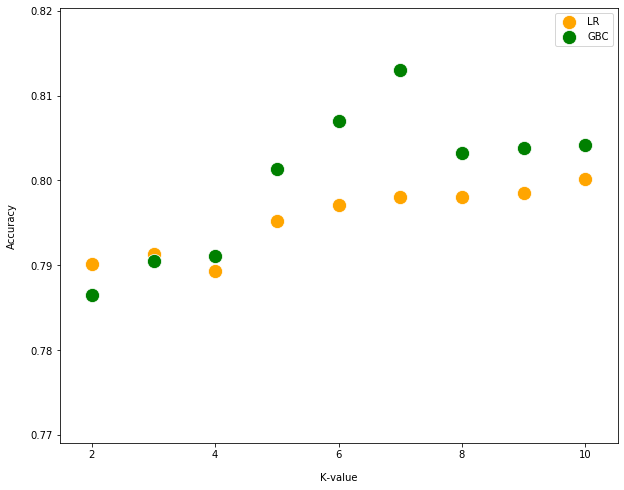

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_LR_mean["k_values"],
    y=df_LR_mean["accuracies"],
    color="orange",
    s=200,
    label="LR",
)
sns.scatterplot(
    x=df_GBC_mean["k_values"],
    y=df_GBC_mean["accuracies"],
    color="g",
    s=200,
    label="GBC",
)
plt.xlabel("K-value", labelpad=13)
plt.ylabel("Accuracy", labelpad=13)
ax = plt.gca()

The highest accuracy for GBC was obtained with a **K=7** and for LR, **K=10**. The highest precision for GBC was found with **K=7** and for LR, with **K=8**. The highest recall for GBC was found with **K= 6** and for LR, **K=3**.

## Conclusions
The best value of K depends on the aplication of my model. If it is critical for my model to get false positives, its precision should be the target for improvement. However, if its critical to get false negatives, its recall should be the target.<br>A model that classifies cancer in patients should prevent from having false positives, as it can be very harmful for a patient to get into treatment without having the disease or simply by the psicological effects of getting the bad results. On the other hand, a model that classifies areas into critical or not for yellow fever disease in a city must not have a high number of false negatives, as it could lead to a low response from the government in order to prevent the specific area against yellow fever.<br> With this said, for the wine dataset its is not critical to have false negatives nor false positives. I believe the best choice would be to have a good trade precision-recall as we seek for a reasonable accuracy value.